# ML & DL Model Comparison for News Sentiment Analysis

This notebook trains and compares multiple models including Traditional ML (Logistic Regression, SVM, etc.) and Deep Learning (LSTM, FinBERT) to classify the sentiment of financial news headlines.

**Note:** Deep Learning models (especially BERT) require significant computational resources (GPU recommended).

In [ ]:
# Install necessary libraries if not present
!pip install tensorflow transformers torch xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Deep Learning Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

## 1. Load and Preprocess Data

In [ ]:
file_path = '/content/sample_data/News_sentiment_Jan2017_to_Apr2021.csv'
try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded: {df.shape}")
except FileNotFoundError:
    print("Dataset not found. Please check the path.")

# Cleaning
df = df.dropna(subset=['Title', 'sentiment'])

# Limit to first 10000 rows as requested

# Sampling for demo speed (Optional: Comment out to use full dataset)
# df = df.sample(2000, random_state=42)
# print(f"Using subset: {df.shape}")

X_text = df['Title'].values
y_text = df['sentiment'].values

# Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_text)
num_classes = len(np.unique(y_encoded))
print(f"Classes: {le.classes_}")

# Global Results Dictionary
model_results = {}

Dataset loaded: (200500, 6)
Classes: ['NEGATIVE' 'POSITIVE']


## 2. Traditional Machine Learning Models

In [ ]:
# TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(X_text)

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

ml_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

for name, model in ml_models.items():
    print(f"Training {name}...")
    model.fit(X_train_ml, y_train_ml)
    y_pred = model.predict(X_test_ml)
    acc = accuracy_score(y_test_ml, y_pred)
    model_results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Training Logistic Regression...
Logistic Regression Accuracy: 0.7708
Training Naive Bayes...
Naive Bayes Accuracy: 0.7422
Training SVM...
SVM Accuracy: 0.7712
Training Random Forest...
Random Forest Accuracy: 0.7459
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.7144


## 3. Deep Learning: LSTM
We use Keras/TensorFlow to build an LSTM model.

In [ ]:
# Tokenization
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_text)

X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, pd.get_dummies(y_encoded).values, test_size=0.2, random_state=42)

# Model Architecture
model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_pad.shape[1]))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(num_classes, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Training LSTM...")
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

# Evaluation
loss, acc = model_lstm.evaluate(X_test_lstm, y_test_lstm, verbose=0)
model_results['LSTM'] = acc
print(f"LSTM Accuracy: {acc:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training LSTM...
Epoch 1/3
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 731s 321ms/step - accuracy: 0.7190 - loss: 0.5336 - val_accuracy: 0.7984 - val_loss: 0.4336
Epoch 2/3
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 725s 321ms/step - accuracy: 0.8341 - loss: 0.3689 - val_accuracy: 0.8089 - val_loss: 0.4112
Epoch 3/3
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 730s 323ms/step - accuracy: 0.8649 - loss: 0.3033 - val_accuracy: 0.8138 - val_loss: 0.4159
LSTM Accuracy: 0.8120


## 4. Deep Learning: FinBERT
We fine-tune a pre-trained Financial BERT model.

In [ ]:
# Prepare Dataset for Hugging Face
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load Pre-trained FinBERT
MODEL_NAME = 'ProsusAI/finbert'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model_bert = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_classes, ignore_mismatched_sizes=True)

# We strictly ignore the pre-trained weights mismatch warning for classifier layers as we want to fine-tune

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_text, y_encoded, test_size=0.2, random_state=42)

# Create Datasets
train_dataset = NewsDataset(X_train_bert, y_train_bert, tokenizer)
test_dataset = NewsDataset(X_test_bert, y_test_bert, tokenizer)

# Training Arguments
# Use smaller batch size and fewer epochs to save time/memory in this demo
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch"
)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

print("Training FinBERT (This may take a while)...")
trainer.train()

# Evaluation
eval_result = trainer.evaluate()
bert_acc = eval_result['eval_accuracy'] if 'eval_accuracy' in eval_result else 0.0 # fallback
# If evaluate doesn't return key directly, calculate manually:
preds = trainer.predict(test_dataset)
preds_labels = np.argmax(preds.predictions, axis=1)
bert_acc = accuracy_score(y_test_bert, preds_labels)

model_results['FinBERT'] = bert_acc
print(f"FinBERT Accuracy: {bert_acc:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training FinBERT (This may take a while)...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss
1,0.398200,0.425590
2,0.264800,0.389093


FinBERT Accuracy: 0.8636


## 5. Final Comparison

/tmp/ipython-input-3484719505.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='magma')


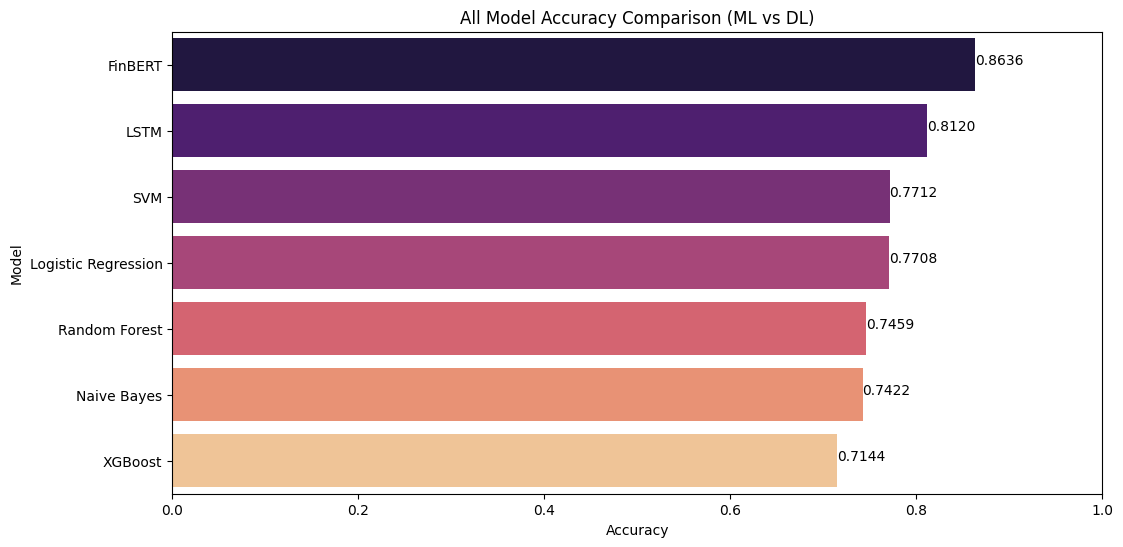

In [ ]:
results_df = pd.DataFrame(list(model_results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='magma')
plt.title('All Model Accuracy Comparison (ML vs DL)')
plt.xlim(0, 1.0)
for index, value in enumerate(results_df['Accuracy']):
    plt.text(value, index, f'{value:.4f}')
plt.show()